In [1]:
from __future__ import annotations
from matplotlib import pyplot as plt
import torch
from jrmpc import jrmpc

In [2]:
# required only for interactive plot
import plotly.graph_objects as go

In [3]:
def interactive_plot(
    data,
    point_size: int = 3,
    opacity: float = 0.8,
    width: int = 500,
    height: int = 500,
):
    if not isinstance(data, (list, tuple)):
        data = [data]
    if isinstance(data, tuple):
        data = list(data)
    for i, x in enumerate(data):
        if isinstance(x, torch.Tensor) and x.is_cuda:
            data[i] = x.cpu()
    traces = list()
    for pointcloud in data:
        x, y, z = pointcloud
        c = pointcloud.norm(dim=0)
        marker_kwargs = dict(size=point_size, opacity=opacity, color=c)
        scatter_kwargs = dict(visible=True, mode='markers', marker=marker_kwargs)
        traces.append(go.Scatter3d(x=x, y=y, z=z, **scatter_kwargs))
    layout = dict(
        width=width, height=height,
        xaxis=dict(range=[0, 1]), yaxis=dict(range=[0, 1]), margin=dict(t=50)
    )
    fig = go.Figure(data=traces, layout=layout)
    fig.show()

In [4]:
def so3_relative_angle(R1, R2):
    """ Geodesic distance in SO(3). R1 & R2 are batches of rotation matrices (B, 3, 3). """
    cos_theta = (torch.einsum('bij,bij->b', R1, R2) - 1) / 2
    cos_theta = torch.clamp(cos_theta, -1, 1)
    return torch.acos(cos_theta) * 180 / torch.pi

___

In [5]:
data = torch.load('sample_data.pt')
views, R_gt = data['views'], data['R_gt']

In [6]:
print(views.shape)
print(R_gt.shape)

torch.Size([100, 3, 1024])
torch.Size([100, 3, 3])


In [7]:
R_hat, t_hat, history = jrmpc(views.cuda(), max_num_iter=20, progress_bar=True, track_history=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [8]:
R_hat, t_hat = R_hat.cpu(), t_hat.cpu()

In [10]:
avg_rotation_error_evolution = [so3_relative_angle(r.mT, R_gt).mean() for r in history['R']] 

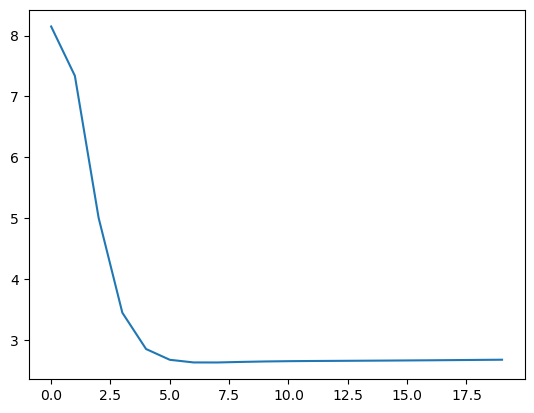

In [11]:
plt.plot(avg_rotation_error_evolution)
plt.show()

In [12]:
final_rotation_errors = so3_relative_angle(R_hat.mT, R_gt)

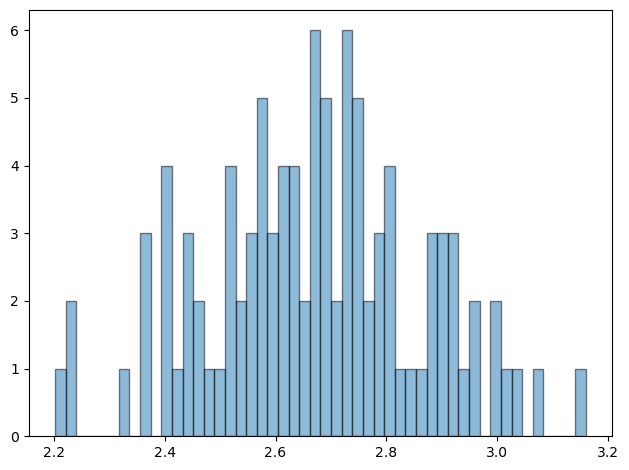

In [13]:
plt.hist(final_rotation_errors, bins=50, edgecolor='k', alpha=0.5)
plt.tight_layout()
plt.show()

In [15]:
V_registered = [r @ v + t for v, r, t in zip(views, R_hat, t_hat)]

In [17]:
# interactive_plot((*views[:5],))
# interactive_plot((*V_registered[:5],))